In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import random 
from tqdm import tqdm 

In [2]:
import matplotlib.colors as mcolors
def get_tsne(X, Y, colors, save_name):
    '''
        @oaram X: np.array of shape (N, channel), N is number of samples
        @param Y: np.array of shape (N, 1) 
        
    '''    
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    X_tsne = tsne.fit_transform(X)
    print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))
    '''嵌入空间可视化'''
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(8, 8))
    for i in tqdm(range(X_norm.shape[0])):
        plt.scatter(X_norm[i, 0], X_norm[i, 1], marker=".", c=mcolors.to_rgba_array(colors[Y[i]]),
                                s=10)
    # plt.legend(('BLA', 'FNH', 'HCC', 'HH', 'ICC', 'LM'), loc='best')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()


In [3]:
import numpy as np
# testx = np.random.rand(1000, 250)
# testy = np.random.randint(0, 5, (1000,1))
colors = [(128, 64, 128),
              (244, 35, 232),
              (250, 170, 160),
              (230, 150, 140),
              (70, 70, 70),
              (102, 102, 156),
              (190, 153, 153),
              (180, 165, 180),
              (150, 100, 100),
              (150, 120, 90),
              (153, 153, 153),
              (153, 153, 153),
              (250, 170, 30),
              (220, 220, 0),
              (107, 142, 35),
              (152, 251, 152),
              (70, 130, 180),
              (220, 20, 60),
              (255, 0, 0),
              (0, 0, 142),
              (0, 0, 70),
              (0, 60, 100),
              (0, 0, 90),
              (0, 0, 110),
              (0, 80, 100),
              (0, 0, 230),
              (119, 11, 32),
              (0, 0, 0)]
colors = np.array(colors)


## 载入模型和数据集，得到不同模型在固定图片上的分类效果并转换为N，C格式

In [4]:
## 载入数据集
from data.cityscapes_eval_dataset import EvalCityscapesRAW
from data.cityscapes_train_dataset import TrainCityscapesRAW
import argparse
import os
import time as t
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2 
from PIL import Image
from utils import *
from commons import * 


dataset = EvalCityscapes(f"/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/cityscapes", res=384, split='val', mode='test',
                                     label_mode='gtFine', long_image=False)
testloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=4,
                                            shuffle=False,
                                            num_workers=12,
                                            pin_memory=True,
                                            collate_fn=collate_eval,
                                            worker_init_fn=worker_init_fn(0))



In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import easydict 
arch = 'swinv2'
method = 'swin_only_LFadd'
in_dim = 256 if arch.startswith('resnet') or (arch == 'swinv2' and method != 'dino') else 1024

args = easydict.EasyDict({
    'data_root': '/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/cityscapes',
    'cityscapes': True,
    'save_root': None,
    'save_model_path': "/home/zhulifu/unsup_seg/train_out",
    'model_dir': "/home/zhulifu/unsup_seg/STEGO-master/models",
    'device': 'cuda',
    'arch': arch,
    'res': 384,
    'tar_res': 80,
    'method': method,
    'label_mode': 'gtFine',
    'long_image': False,
    'in_dim': in_dim,
    'pretrain': False
})
prefix = f'train_linear_{args.arch}_{args.res}_{args.method}'
args.save_root = '/home/zhulifu/unsup_seg/trials_unsupervised_segmentation/train_results/' + prefix
args.save_model_path = args.save_root + '/models/'

model = get_model(args)
epoch = 4

if arch == 'picie':
    if args.cityscapes:
            pth = torch.load('/home/zhulifu/unsup_seg/STEGO-master/saved_models/picie_city.tar')
    else:
        pth = torch.load('/home/zhulifu/unsup_seg/STEGO-master/saved_models/picie_coco.pkl')
    nd = {}
    for key in pth['state_dict'].keys():
        if key.startswith('module.'):
            nd[key[7:]] = pth['state_dict'][key]
    model.load_state_dict(nd)
    # classifier1 = nn.Conv2d(in_channels=args.in_dim, out_channels=27, kernel_size=1, stride=1, padding=0, bias=True)
    # nd = {}
    # for key in pth['classifier1_state_dict'].keys():
    #     if key.startswith('module.'):
    #         nd[key[7:]] = pth['classifier1_state_dict'][key]
    # classifier1.load_state_dict(nd)
elif arch == 'stego':
    pass 
else:
    prefix = f'train_{args.arch}_{args.res}_{args.method}'
    pth = torch.load(os.path.join(args.save_model_path, f'{prefix}_checkpoint_{epoch}.pth.tar'))

    model.load_state_dict(pth['state_dict'], strict=False)
    model.args.method = ''

loaded stated dict for swin, 
<All keys matched successfully>


In [28]:
from tqdm import tqdm 

all_feats = None
all_lbls = None 
model.to('cuda:0')
with torch.no_grad():
    for index, (_, image, label) in enumerate(tqdm(testloader)):
        image = image.to('cuda:0')
        if arch == 'stego':
            feat, _ = model.backbone(image)
        elif arch == 'swinv2':
            feats = model.forward_swin(image, return_feats=True)
            feat = model.decoder(feats[:-1])
        else:
            feat = model(image)
        label = F.interpolate(label.unsqueeze_(0).float(), feat.shape[-2:], mode='nearest')[0].long()
        if all_feats is None:
            all_feats = feat.detach().cpu().numpy()
            all_lbls = label.detach().cpu().numpy()
        else:
            all_feats = np.concatenate((all_feats, feat.detach().cpu().numpy()), 0)
            # print(all_lbls.shape, label.shape)
            all_lbls = np.concatenate((all_lbls, label.detach().cpu().numpy()), 0)
        if all_feats.shape[0] > 9:
            break 
        

  0%|          | 2/869 [00:02<17:46,  1.23s/it]


In [29]:
print(all_feats.shape, all_lbls.shape)
_, c, _, _ = all_feats.shape 

(12, 256, 48, 48) (12, 48, 48)


In [30]:
X = all_feats.transpose(0,2,3,1).reshape(-1, c)
Y = all_lbls.reshape(-1)
print(Y.shape )
ym = Y>-1
nx, ny = X[ym], Y[ym]
print(nx.shape, ny.shape)

(27648,)
(23640, 256) (23640,)


  1%|          | 53/8000 [00:00<00:15, 523.25it/s]

Org data dimension is 256.Embedded data dimension is 2


100%|██████████| 8000/8000 [01:32<00:00, 86.77it/s] 


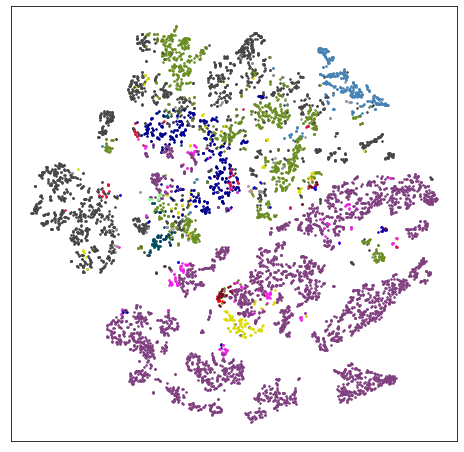

In [32]:
get_tsne(nx[1000:9000], ny[1000:9000], colors / 255, "tsne-D-swinv2-dec-8k.tiff")